In [1]:
!pip install MDAnalysis
!pip install lipyphilic
!pip install hmmlearn

In [2]:
import pathlib
import pickle  # this library is used for saving the analysis objects to file
import joblib
import os

import numpy as np
import MDAnalysis as mda
import lipyphilic as lpp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.mixture
import hmmlearn.hmm
import matplotlib
import plotly.graph_objects as go

from tqdm.auto import tqdm


from lipyphilic.leaflets.assign_leaflets import AssignLeaflets, AssignCurvedLeaflets
from lipyphilic.analysis.order_parameter import SCC
from lipyphilic.analysis.z_angles import ZAngles
from lipyphilic.analysis.area_per_lipid import AreaPerLipid
from lipyphilic.analysis.z_positions import ZPositions
from lipyphilic.analysis.memb_thickness import MembThickness
from lipyphilic.plotting import JointDensity
from lipyphilic.analysis.z_thickness import ZThickness
from lipyphilic.plotting import ProjectionPlot
from lipyphilic.analysis.registration import Registration


from MDAnalysis.analysis.lineardensity import LinearDensity
from MDAnalysis.lib.mdamath  import normal
from MDAnalysis.lib.mdamath import norm
from MDAnalysis.lib.mdamath import angle
from MDAnalysis.lib.mdamath import make_whole


Vamos a chequear los archivos de la carpeta para saber què archivos cargar

In [3]:
#This cell should be deleted if the files are downloaded and the notebooks executed locally
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Step 1: Define the folder
folder_path = "/content/drive/Shareddrives/Noe-1/Soft-matter-paper/DMs-libres/semiiso_00znpc"

# Step 2: Search for unique `.tpr` and `.xtc` files in the folder
tpr_file = None
xtc_file = None

for fname in os.listdir(folder_path):
    if fname.endswith(".tpr"):
        if tpr_file is not None:
            raise ValueError("More than one .tpr file found in the folder.")
        tpr_file = os.path.join(folder_path, fname)
    elif fname.endswith(".xtc"):
        if xtc_file is not None:
            raise ValueError("More than one .xtc file found in the folder.")
        xtc_file = os.path.join(folder_path, fname)

# Check if both files were found
if tpr_file is None or xtc_file is None:
    raise FileNotFoundError("Could not find both .tpr and .xtc files in the folder.")

# Step 3: Load with MDAnalysis
u = mda.Universe(tpr_file, xtc_file)

print("Trajectory loaded successfully.")

Trajectory loaded successfully.


/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/XDR.py:253: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn(


# Vamos a ver con el perfil en Z

In [5]:
# Tomamos el centro de la bicapa

P_center_z_positions = ZPositions(
  universe=u,
  lipid_sel="resname DPPC",
  height_sel="name P8",
  n_bins=10
)

P_center_z_positions.run(start=None, stop=None, step=5)


In [6]:
# Calculate the average of the filtered results
P_center_results_z = P_center_z_positions.z_positions

valid_values_center = P_center_results_z[~np.isnan(P_center_results_z)]
average_P_center = np.mean(valid_values_center)
std_P_center = np.std(valid_values_center)
print(average_P_center)
print(std_P_center)

0.03207672870551971
19.25579849514466


In [7]:
## Ahora tomamos cada hemicapa. En este caso, tras analizar el .gro
## Veo que cada 16 lipidos cambia a la otra hemicapa

P_atoms = u.select_atoms("(resid 1 to 10) and  name P8")

P_up_z_positions = P_atoms.positions[P_atoms.positions[:, 2] > average_P_center]
#print(P_up_z_positions)
# Tomamos el limite superior de la bicapa

P_up_z_positions = ZPositions(
  universe=u,
  lipid_sel="resname DPPC",
#  height_sel="name P8 and (resid 11 to 20 or resid 32 to 42 or resid 54 to 63 or resid 77 to 90)",
  height_sel="(resid 1 to 10) and  name P8",
  n_bins=10
)

P_up_z_positions.run(start=None, stop=None, step=5)

# Calculate the average of the filtered results
P_up_results_z = P_up_z_positions.z_positions

valid_values_up = P_up_results_z[~np.isnan(P_up_results_z)]
average_P_up = np.mean(valid_values_up)
std_P_up = np.std(valid_values_up)
print(average_P_up)
print(std_P_up)



-18.96204979177669
2.5473478892480284


In [8]:
# tomamos el limite inferior de la bicapa

P_down_z_positions = ZPositions(
  universe=u,
  lipid_sel="resname DPPC",
  height_sel="(resid 21 to 31) and  name P8",
#  height_sel="name P8 and (resid 11 to 20 or resid 32 to 42 or resid 54 to 63 or resid 77 to 90)",
  n_bins=10
)

P_down_z_positions.run(start=None, stop=None, step=5)

# Calculate the average of the filtered results
P_down_results_z = P_down_z_positions.z_positions

valid_values_down = P_down_results_z[~np.isnan(P_down_results_z)]
average_P_down = np.mean(valid_values_down)
std_P_down = np.std(valid_values_down)
print(average_P_down)
print(std_P_down)



19.084236898643667
2.5336650006654


In [9]:
## Ahora tomo las posiciones del ZnPc
from lipyphilic.analysis.z_positions import ZPositions

z_positions = ZPositions(
  universe=u,
  lipid_sel="resname DPPC",
  height_sel="name ZN and resname ZNPC",
  n_bins=10
)

z_positions.run(start=None, stop=None, step=5)

In [10]:
# Vemos algunas variables importantes
# Calculate the position of ZnPc Center
average_z = np.mean(z_positions.z_positions, axis=0)

# Calculate the average Z-position of Phosphates
average_down_z = np.mean(P_down_z_positions.z_positions, axis=0)

# Calculate the average Z-position of Phosphates
average_up_z = np.mean(P_up_z_positions.z_positions, axis=0)


# Get the number of frames
num_frames_z = len(average_z)

# Create the x-axis values (frame numbers)
frames_z = np.arange(num_frames_z)

# Calculate the average of the last 100 values
last_100_avg_z = np.mean(average_z[-100:])


In [11]:
# Create the Plotly figure
fig = go.Figure()

# Add the ZnPc Z Position trace
fig.add_trace(go.Scatter(
    x=frames_z / 2000,  # Divide x values by 10000
    y=average_z,
    mode='markers',
    name='ZnPc Z Position'
))

# Add the first Phosphates trace
fig.add_trace(go.Scatter(
    x=frames_z / 2000,  # Divide x values by 10000
    y=average_up_z,
    mode='markers',
    name='Phosphates',
    marker=dict(color='purple')
))

# Add the second Phosphates trace without a legend label
fig.add_trace(go.Scatter(
    x=frames_z / 2000,  # Divide x values by 10000
    y=average_down_z,
    mode='markers',
    showlegend=False,  # Hide this trace from the legend
    marker=dict(color='purple'),
))

# Add the dashed line for z=0
fig.add_shape(
    type="line",
    x0=0,
    x1=num_frames_z / 20000,  # Adjust x-axis scale
    y0=0,
    y1=0,
    line=dict(color="black", dash="dash"),
    name="Membrane Center"
)

# Add the dashed lines for average positions
fig.add_shape(
    type="line",
    x0=0,
    x1=num_frames_z / 20000,  # Adjust x-axis scale
    y0=average_P_up,
    y1=average_P_up,
    line=dict(color="white", dash="dash")
)

fig.add_shape(
    type="line",
    x0=0,
    x1=num_frames_z / 20000,  # Adjust x-axis scale
    y0=average_P_down,
    y1=average_P_down,
    line=dict(color="white", dash="dash")
)

# Update the layout of the plot
fig.update_layout(
    title="ZnPc z Position vs. Frame",
    xaxis_title="Time (μs)",  # Update axis label
    yaxis_title="z Position (Å)"
)

# Display the plot
fig.show()


# Hago el grafico de las posiciones con el programa seaborn

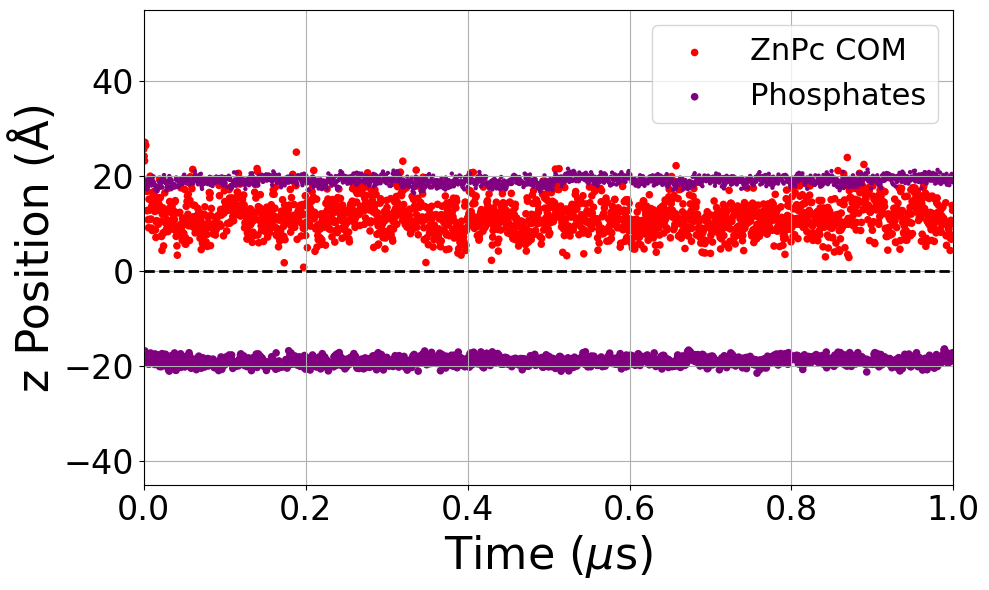

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: ZnPc ZN Position vs. Frame
fig1, ax1 = plt.subplots(figsize=(10, 6))  # Tamaño ajustado para el primer gráfico
sns.scatterplot(x=frames_z / 2000, y=average_z, ax=ax1, marker='o', color='red', label='ZnPc COM', s=30, edgecolor='none')
sns.scatterplot(x=frames_z / 2000, y=average_up_z, ax=ax1, marker='o', color='purple', label='Phosphates', s=30, edgecolor='none')
sns.scatterplot(x=frames_z / 2000, y=average_down_z, ax=ax1, marker='o', color='purple', s=10, edgecolor='none')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=2)

# Configuración del primer gráfico
ax1.set_xlabel(r"Time ($\mu$s)", fontsize=32)
ax1.set_ylabel('z Position (Å)', fontsize=32)
ax1.set_xlim(0, 1)  # Límite en x
ax1.set_ylim(-45, 55)  # Límite en y
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=24)

# Ubicacion de la cajita de label
ax1.legend(loc='upper right', fontsize=22)


# Mostrar el primer gráfico
plt.tight_layout()
plt.show()



# Hago el grafico combinado posicion y luego el conteo

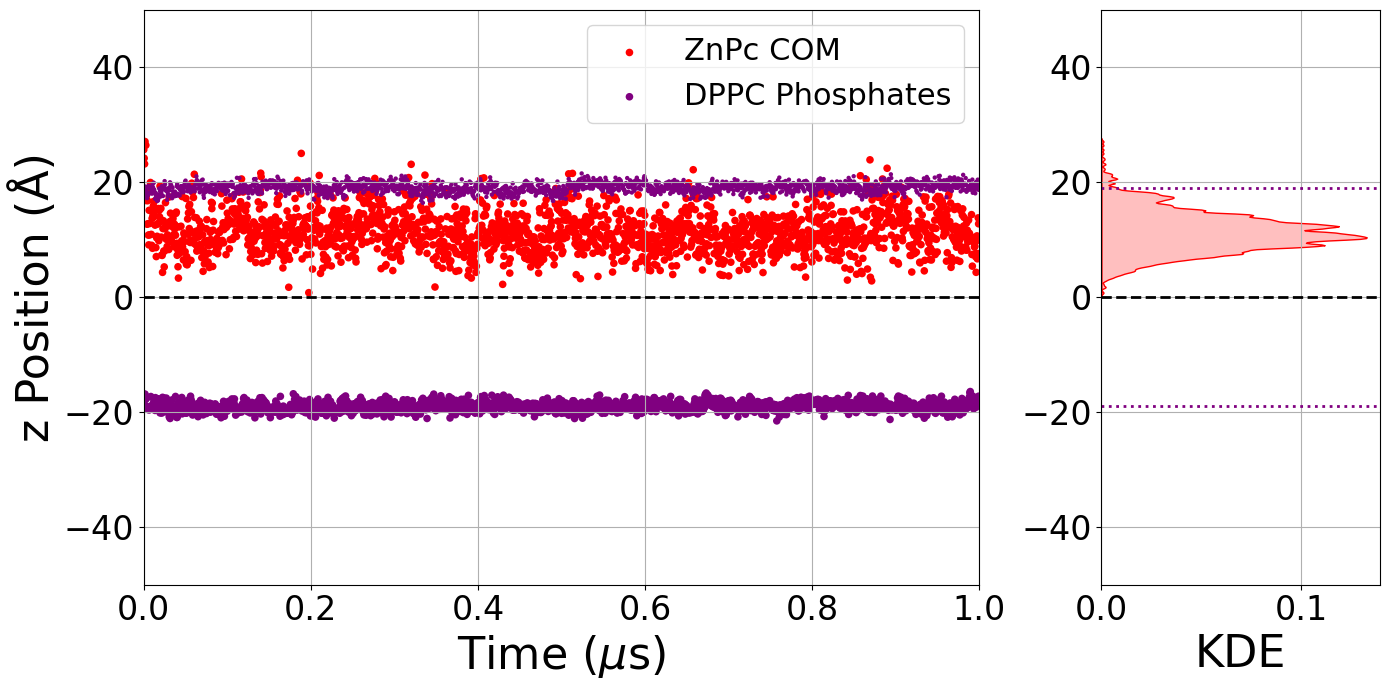

In [13]:
# Create the figure and axes with the specified aspect ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [3, 1]})

# Plot the ZnPc ZN Position vs. frame using Seaborn
sns.scatterplot(x=frames_z / 2000, y=average_z, ax=ax1, marker='o', color='red', label='ZnPc COM', s=30, edgecolor='none')
sns.scatterplot(x=frames_z / 2000, y=average_up_z, ax=ax1, marker='o', color='purple', label='DPPC Phosphates', s=30, edgecolor='none')
sns.scatterplot(x=frames_z / 2000, y=average_down_z, ax=ax1, marker='o', color='purple', s=10, edgecolor='none')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=2)

# Update x-axis label
ax1.set_xlabel(r"Time ($\mu$s)", fontsize=32)
ax1.set_ylabel('z Position (Å)', fontsize=32)
ax1.grid(True)

# Increase tick label font size for ax1
ax1.tick_params(axis='both', which='major', labelsize=24)

# Plot the KDE of the average_z variable
sns.kdeplot(y=average_z, ax=ax2, fill=True, color='red', bw_adjust=0.25)
ax2.set_xlabel('KDE', fontsize=32)
ax2.grid(True)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax2.axhline(average_P_down, color='purple', linestyle='dotted', linewidth=2, label='DPPC Phosphates')
ax2.axhline(average_P_up, color='purple', linestyle='dotted', linewidth=2, label='DPPC Phosphates')

# Set x-axis limits
x_min = 0
x_max = 1
ax1.set_xlim(x_min, x_max)

# Set y-axis limits
y_min_2 = -50
y_max_2 = 50
ax1.set_ylim(y_min_2, y_max_2)
ax2.set_ylim(y_min_2, y_max_2)

# Increase tick label font size for ax2
ax2.tick_params(axis='both', which='major', labelsize=24)
ax1.legend(fontsize=22)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [14]:
# Guardo la informacion en  un DAtAFrame, y luego en un csv
df_positions = pd.DataFrame({
    "frames_z": frames_z,
    "average_z": average_z,
    "average_P_down": [average_P_down] * len(frames_z),  # Repeat for all frames
    "average_P_up": [average_P_up] * len(frames_z)      # Repeat for all frames
})

# Save the DataFrame to a CSV file
output_file = "z_positions.csv"
df_positions.to_csv(output_file, index=False)

print(f"DataFrame saved to {output_file}")

DataFrame saved to z_positions.csv


#Si quisieras trabajar por fuera primero cargar el df_positions y luego realizar los graficos de estos

# Ahora el mismo grafico, pero con la densidad:

In [15]:
### Listo el DataFrame guardado
### Leo el DataFrame de la densidad :
df_f_name = r'linear_density-OK.csv'
# Define la ruta del archivo
file_path_dens = os.path.join(folder_path, 'Analisis', df_f_name)


# Leer el archivo CSV
new_df = pd.read_csv(file_path_dens)

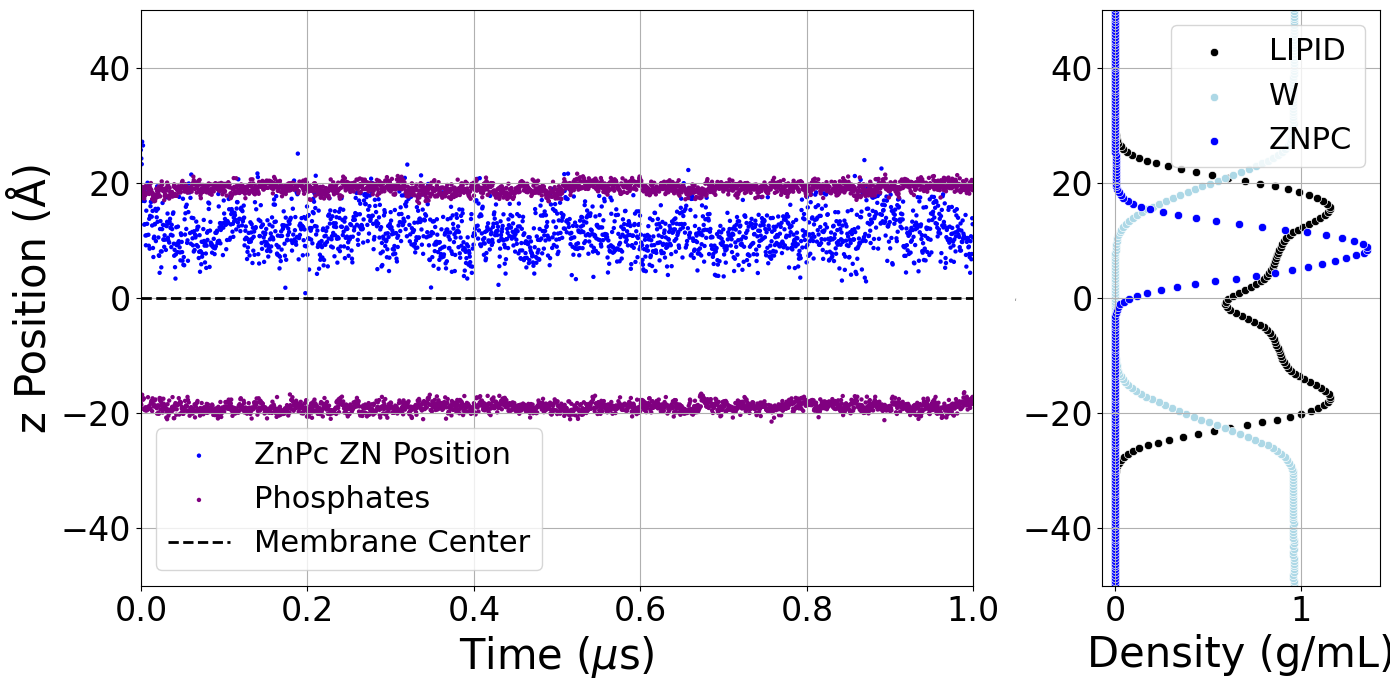

In [16]:
# Create the figure and axes with the specified aspect ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [3, 1]})

# Plot the ZnPc ZN Position vs. frame using Seaborn
sns.scatterplot(x=frames_z / 2000, y=average_z, ax=ax1, marker='o', color='blue', label='ZnPc ZN Position', s=10, edgecolor='none')
sns.scatterplot(x=frames_z / 2000, y=average_up_z, ax=ax1, marker='o', color='purple', label='Phosphates', s=10, edgecolor='none')
sns.scatterplot(x=frames_z / 2000, y=average_down_z, ax=ax1, marker='o', color='purple', s=10, edgecolor='none')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=2, label='Membrane Center')

# Update x-axis label
ax1.set_xlabel(r"Time ($\mu$s)", fontsize=30)
ax1.set_ylabel('z Position (Å)', fontsize=30)
ax1.grid(True)

# Increase tick label font size for ax1
ax1.tick_params(axis='both', which='major', labelsize=24)


# Plot the smoothed lines with shading
sns.scatterplot(y='bin', x='Lipid_smooth', data=new_df, label='LIPID', color='black',ax=ax2)
sns.scatterplot(y='bin', x='W_smooth', data=new_df, label='W', color='lightblue',ax=ax2)
sns.scatterplot(y='bin', x=new_df['ZNPC_smooth'] * 50, data=new_df, label='ZNPC', color='blue',ax=ax2)



# Add labels and title
ax2.set_ylabel('z(nm)',fontsize=0.001)
ax2.set_xlabel('Density (g/mL)',fontsize=30)
#ax2.set_title('Linear Density Profile with Moving Average Smoothing')

# Add legend
ax2.legend()
ax2.grid(True)

ax2.legend(loc='best', fontsize=22)

# Show the plot
#ax2.show()


# Set x-axis limits
x_min = 0
x_max = 1
ax1.set_xlim(x_min, x_max)

# Set y-axis limits
y_min_2 = -50
y_max_2 = 50
ax1.set_ylim(y_min_2, y_max_2)
ax2.set_ylim(y_min_2, y_max_2)

# Increase tick label font size for ax2
ax2.tick_params(axis='both', which='major', labelsize=24)
ax1.legend(fontsize=22)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Calculamos el Angulo de orientacion de la ZnPc con el eje Z


In [17]:
##Creo el primer array con el primer àngulo

z_angles = ZAngles(
  universe=u,
  atom_A_sel="resname ZNPC and name N1",
  atom_B_sel="resname ZNPC and name N7"
)

z_angles.run(
  start=None,
  stop=None,
  step=5,
  verbose=True
)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [18]:
# Calculate the average of the filtered results
z_angles_results = z_angles.z_angles

z_angles_ave = np.mean(z_angles_results)

# Print the average
print(z_angles_ave)


100.90719328799908


In [19]:
##Creo el primer array con el segundo  àngulo

z_angles_2 = ZAngles(
  universe=u,
  atom_A_sel="resname ZNPC and name N3",
  atom_B_sel="resname ZNPC and name N8"
)

z_angles_2.run(
  start=None,
  stop=None,
  step=5,
  verbose=True
)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [20]:
# Calculate the average of the filtered results
z_angles_results_2 = z_angles_2.z_angles

z_angles_ave_2 = np.mean(z_angles_results_2)

# Print the average
print(z_angles_ave_2)

76.16062088162563


# Calculamos el Tilt Angle del plano de la ZnPc respecto al eje Z Normal a la membrana
## Seleccion de los atomos de la ZnPc (o TAZnPc) para calcular el plano determinado por la Ftalo


In [21]:
## Seleccion de los atomos de la ZnPc (o TAZnPc) para calcular el plano determinado por la Ftalo

sel_NA = u.select_atoms("resname ZNPC and name N1")
sel_NB = u.select_atoms("resname ZNPC and name N3")
sel_NC = u.select_atoms("resname ZNPC and name N7")
sel_ND = u.select_atoms("resname ZNPC and name N8")

In [22]:
#Hago el analisis
STEP=5
angles_1 = []
for ts in u.trajectory[::STEP]:
    r_1 = sel_NA.positions - sel_NC.positions
    r_2 = sel_NB.positions - sel_ND.positions

    vec_z = np.array([0, 0, 1])

    # Calculate the normal vector of the plane defined by r_1 and r_2
    normal_vector = np.cross(r_1, r_2)

    # Normalize the normal vector
    normal_vector_normalized = normal_vector / np.linalg.norm(normal_vector, axis=1)[:, np.newaxis]

    # Calculate the angle between the normal vector and vec_z
    angle_1 = np.degrees(np.arccos(np.clip(np.dot(normal_vector_normalized, vec_z), -1.0, 1.0)))

    # Take the mean of the angle array to reduce to a single value per timestep
    mean_angle = np.mean(angle_1)

    angles_1.append(mean_angle)


In [23]:
# Modifica los valroes de la lista angles_1 a angles_2 con la siguiente regla.:
# A los valores mayores a 90, restarle 90 grados.
# los otros valores que queden igual

angles_2 = []
for angle in angles_1:
  if angle > 90:
    angles_2.append(90 - (angle - 90))
  else:
    angles_2.append(angle)



In [24]:
#Ahora hago el gràfico - esta primer celda se puede ocultar
# Calculate the angle vs time
average_z_angle = np.mean(z_angles.z_angles, axis=0)
average_z_angle_2 = np.mean(z_angles_2.z_angles, axis=0)

# Get the number of frames
num_frames = len(average_z_angle)

# Create the x-axis values (frame numbers)
frames = np.arange(num_frames)



average_z_angle_rad = np.deg2rad(average_z_angle)
transf_z_angle_rad = np.arcsin(np.sin(average_z_angle_rad))
transf_z_angle_deg = np.rad2deg(transf_z_angle_rad)

average_z_angle_rad_2 = np.deg2rad(average_z_angle_2)
transf_z_angle_rad_2 = np.arcsin(np.sin(average_z_angle_rad_2))
transf_z_angle_rad_3 = np.arccos(np.sin(average_z_angle_rad_2))

transf_z_angle_deg_2 = np.rad2deg(transf_z_angle_rad_2)
transf_z_angle_deg_3 = np.rad2deg(transf_z_angle_rad_3)
# @title

# Get the number of frames
num_frames = len(average_z_angle)

# Create the x-axis values (frame numbers)
frames = np.arange(num_frames)


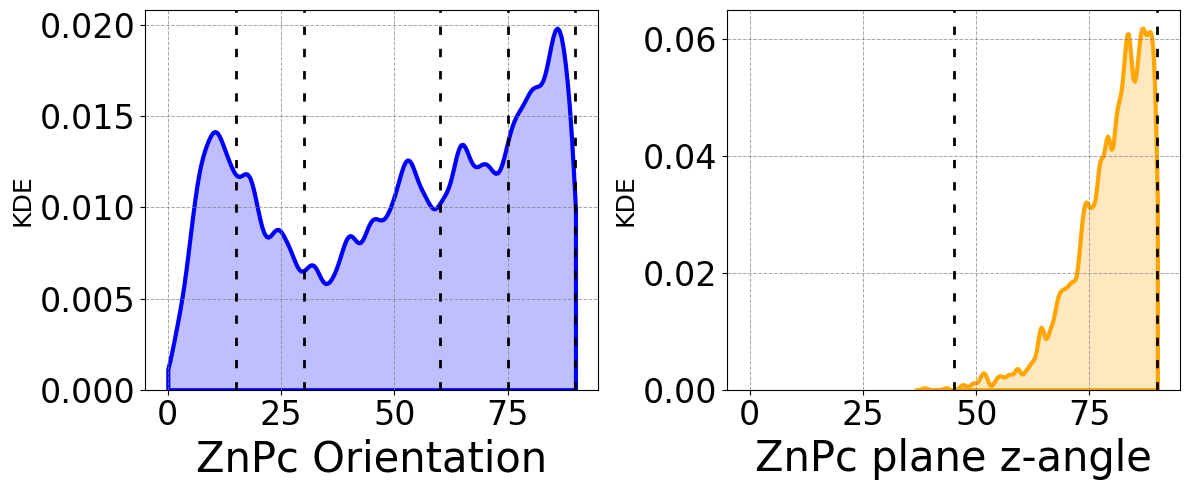

In [25]:
# Create the figure and axes with the specified aspect ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})

# Plot the KDE of the first dataset with transposed axes on ax1
sns.kdeplot(x=transf_z_angle_deg, ax=ax1, fill=True, color='blue', bw_adjust=0.25, clip=(0, 90), linewidth=3.0)
ax1.set_ylabel('KDE', fontsize=18)  # Transposed to y-axis label
ax1.grid(True)
ax1.axvline(x=15, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label='conf limits')  # Vertical lines
ax1.axvline(x=30, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax1.axvline(x=60, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax1.axvline(x=75, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax1.axvline(x=90, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)

# Set x-axis limits for ax1
x_min_1 = -5
x_max_1 = 95
ax1.set_xlim(x_min_1, x_max_1)

# Plot the KDE of the second dataset with transposed axes on ax2
sns.kdeplot(x=angles_2, ax=ax2, fill=True, color='orange', bw_adjust=0.35, clip=(0, 90), linewidth=3.0)
ax2.set_ylabel('KDE', fontsize=18)  # Transposed to y-axis label
ax2.grid(True)
ax2.axvline(x=45, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label='conf limits')  # Vertical lines
ax2.axvline(x=90, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)

# Set x-axis limits for ax2
x_min_2 = -5
x_max_2 = 95
ax2.set_xlim(x_min_2, x_max_2)


ax2.set_xlabel('ZnPc plane z-angle',fontsize=30)
ax1.set_xlabel('ZnPc Orientation',fontsize=30)

# Parametros de los graficos
ax1.tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


# Esta es otra opcion del grafico de distribuciones

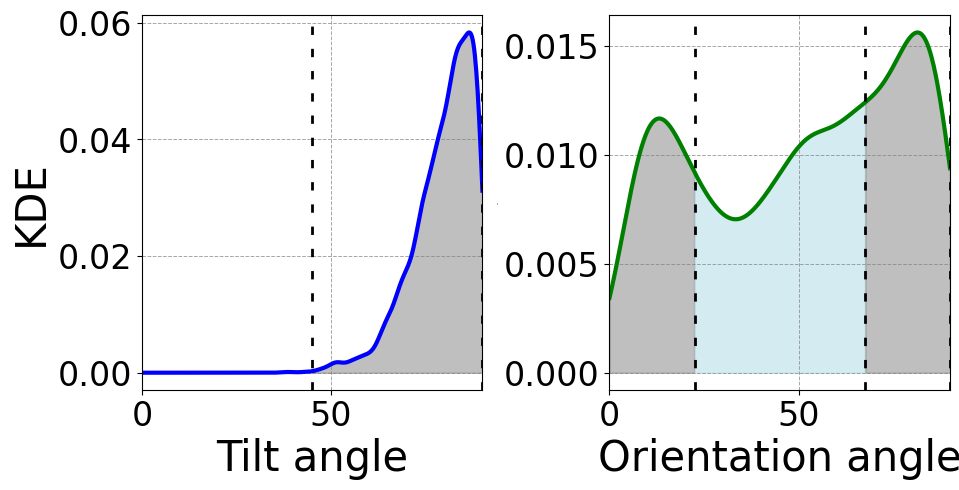

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Compute KDE data manually
def compute_kde(data, bw_adjust, x_range):
    kde = gaussian_kde(data, bw_method=bw_adjust)
    x = np.linspace(x_range[0], x_range[1], 500)  # Create 500 points in the specified range
    y = kde(x)
    return x, y

# Define datasets and KDE parameters
x1_data, y1_data = compute_kde(transf_z_angle_deg, bw_adjust=0.2, x_range=(0, 90))
x2_data, y2_data = compute_kde(angles_2, bw_adjust=0.2, x_range=(0, 90))

# Create the figure and axes
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(9.7, 5), gridspec_kw={'width_ratios': [1, 1]})

# --- Plot the Left Graph ---
ax1.plot(x1_data, y1_data, color='green', linewidth=3.0)  # Plot the KDE curve

# Si comento estas lineas no queda pintado
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 0) & (x1_data <= 22.5), color='gray', alpha=0.5)
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 22.5) & (x1_data <= 67.5), color='lightblue', alpha=0.5)
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 67.5), color='gray', alpha=0.5)

# Add vertical lines and labels
for value in [22.5, 67.5, 90]:
    ax1.axvline(x=value, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax1.set_ylabel('KDE', fontsize=0)
ax1.set_xlabel('Orientation angle', fontsize=30)
ax1.set_xlim(-5, 95)
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

# --- Plot the Right Graph ---
ax2.plot(x2_data, y2_data, color='blue', linewidth=3.0)  # Plot the KDE curve

# Si comento estas lineas no queda pintado
ax2.fill_between(x2_data, 0, y2_data, where=(x2_data < 45), color='lightblue', alpha=0.5)
ax2.fill_between(x2_data, 0, y2_data, where=(x2_data >= 45), color='gray', alpha=0.5)

# Add vertical lines and labels
for value in [45, 90]:
    ax2.axvline(x=value, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax2.set_ylabel('KDE', fontsize=30)
ax2.set_xlabel('Tilt angle', fontsize=30)
ax2.set_xlim(-5, 95)
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

# Set y-axis limits
x_min_a = 0
x_max_a = 90
ax1.set_xlim(x_min_a, x_max_a)
ax2.set_xlim(x_min_a, x_max_a)



# Adjust layout and show the plots
ax1.tick_params(axis='both', which='major', labelsize=24)
ax2.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


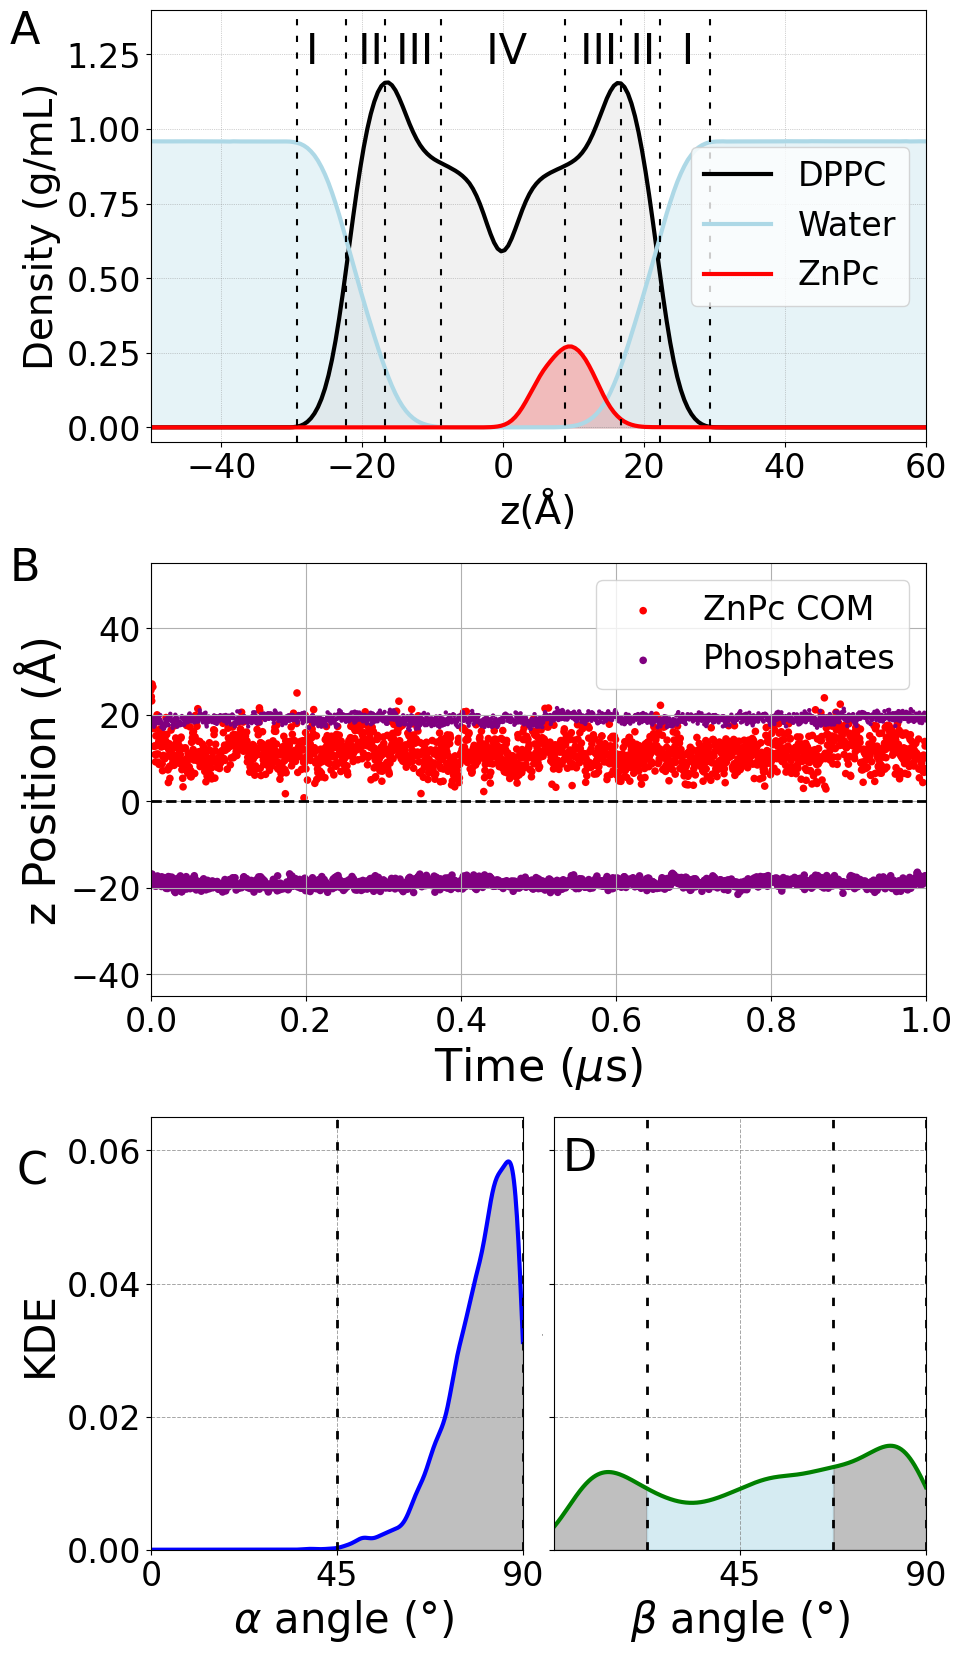

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

# Assume the necessary data (`new_df`, `Offset`, etc.) is already prepared.

# Create a figure and 3 subplots (vertically stacked)
fig, axes = plt.subplots(3, 1, figsize=(10, 20), gridspec_kw={'hspace': 0.28})  # Adjust hspace for spacing

# --- Plot 1 ---
Offset = -0.85

sns.lineplot(ax=axes[0],x=new_df['bin'] - Offset , y='Lipid_smooth', data=new_df, label='DPPC', color='black',  linewidth=3.0)
sns.lineplot(ax=axes[0], x=new_df['bin'] - Offset, y='W_smooth', data=new_df, label='Water', color='lightblue', linewidth=3.0)
sns.lineplot(ax=axes[0], x=new_df['bin'] - Offset, y=new_df['ZNPC_smooth'] * 10, data=new_df, label='ZnPc', linewidth=3.0, color='red')

# Fill the area under ZNPC_smooth curve
axes[0].fill_between(new_df['bin'] - Offset, new_df['ZNPC_smooth'] * 10, color='red', alpha=0.3)
# Fill the area under ZNPC_smooth curve
axes[0].fill_between(new_df['bin'] - Offset, new_df['W_smooth'], color='lightblue', alpha=0.3)
axes[0].fill_between(new_df['bin'] - Offset, new_df['Lipid_smooth'], color='lightgray', alpha=0.3)



# Add a dotted line at the maximum of Gli_smooth series
max_gli_y = new_df['Gli_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_gli_x = new_df['bin'][new_df['Gli_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_gli_x_2 = max_gli_x * (-1)

max_tail_y = new_df['Tail_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_tail_x = new_df['bin'][new_df['Tail_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_tail_x_2 = max_tail_x * (-1)


# Set tolerance values to make np.isclose less strict
tolerance_rtol = 1e-2  # Relative tolerance, can be adjusted as needed
tolerance_atol = 1e-1  # Absolute tolerance, can be adjusted as needed


# Find the points where W_smooth and DPPC_smooth are approximately equal
equal_point = new_df[np.isclose(new_df['W_smooth'], new_df['Lipid_smooth'], rtol=tolerance_rtol, atol=tolerance_atol)]
if not equal_point.empty:
    equal_x = equal_point['bin'].iloc[0] - Offset
    equal_x_2 = equal_x * (-1)
    axes[0].axvline(x=equal_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    axes[0].axvline(x=equal_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)


# Find the point where DPPC_smooth is higher than 0.1 and plot a vertical line
dppc_point = new_df[new_df['Lipid_smooth'] > 0.001]
if not dppc_point.empty:
    dppc_x = dppc_point['bin'].iloc[0] - Offset
    dppc_x_2 = dppc_x * (-1)
    axes[0].axvline(x=dppc_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    axes[0].axvline(x=dppc_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)

axes[0].axvline(x=max_gli_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
axes[0].axvline(x=max_gli_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
axes[0].axvline(x=max_tail_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
axes[0].axvline(x=max_tail_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)



# Add labels and title
axes[0].set_xlabel('z(Å)',fontsize=28)
axes[0].set_ylabel('Density (g/mL)',fontsize=28)
#plt.title('Linear Density Profile ',fontsize=28)

# Add legend
axes[0].legend(loc='center right', fontsize=24)
axes[0].set_xlim(-50, 60)
axes[0].set_ylim(-0.05, 1.40)
axes[0].tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
axes[0].grid(True, which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.7)

# Add the text with the regions info
axes[0].text(
    -28, 1.22,  # x, y coordinates of the text in data units
    'I   II III    IV    III II  I',  # The text to display
    fontsize=30,  # Font size of the text
    bbox=dict(facecolor='white', alpha=0.0,edgecolor='white' )  # Text box style
)
# --- Plot 2 ---

sns.scatterplot(ax=axes[1], x=frames_z / 2000, y=average_z, marker='o', color='red', label='ZnPc COM', s=30, edgecolor='none')
sns.scatterplot(ax=axes[1],x=frames_z / 2000, y=average_up_z, marker='o', color='purple', label='Phosphates', s=30, edgecolor='none')
sns.scatterplot(ax=axes[1],x=frames_z / 2000, y=average_down_z, marker='o', color='purple', s=10, edgecolor='none')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)

# Configuración del primer gráfico
axes[1].set_xlabel(r"Time ($\mu$s)", fontsize=32)
axes[1].set_ylabel('z Position (Å)', fontsize=32)
axes[1].set_xlim(0, 1)  # Límite en x
axes[1].set_ylim(-45, 55)  # Límite en y
axes[1].grid(True)
axes[1].tick_params(axis='both', which='major', labelsize=24)

# Ubicacion de la cajita de label
axes[1].legend(loc='upper right', fontsize=24)

#################

# --- Plot 3: Two subplots side-by-side ---
# Divide the third subplot into two sub-axes
#axes[2].remove()
# --- Plot 3: Two subplots side-by-side ---
# Divide the third subplot into two sub-axes

axes[2].axis('off')


# Compute KDE data manually
def compute_kde(data, bw_adjust, x_range):
    kde = gaussian_kde(data, bw_method=bw_adjust)
    x = np.linspace(x_range[0], x_range[1], 500)  # Create 500 points in the specified range
    y = kde(x)
    return x, y

# Define datasets and KDE parameters
x1_data, y1_data = compute_kde(transf_z_angle_deg, bw_adjust=0.2, x_range=(0, 90))
x2_data, y2_data = compute_kde(angles_2, bw_adjust=0.2, x_range=(0, 90))

# Create the figure and axes
ax2 = axes[2].inset_axes([0.0, 0.0, 0.48, 1.0])  # [x, y, width, height]
ax1 = axes[2].inset_axes([0.52, 0.0, 0.48, 1.0])
# --- Plot the Left Graph ---
ax1.plot(x1_data, y1_data, color='green', linewidth=3.0)  # Plot the KDE curve

# Si comento estas lineas no queda pintado
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 0) & (x1_data <= 22.5), color='gray', alpha=0.5)
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 22.5) & (x1_data <= 67.5), color='lightblue', alpha=0.5)
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 67.5), color='gray', alpha=0.5)

# Add vertical lines and labels
for value in [22.5, 67.5, 90]:
    ax1.axvline(x=value, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax1.set_ylabel('KDE', fontsize=0)
ax1.set_xlabel(r'$\beta$ angle (°)', fontsize=30)  # Combining text and Greek letter
#ax1.set_xlabel('$\beta$(°)', fontsize=30)
ax1.set_xlim(-5, 95)
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)
ax1.set_xticks([45, 90])  # Set tick positions

# --- Plot the Right Graph ---
ax2.plot(x2_data, y2_data, color='blue', linewidth=3.0)  # Plot the KDE curve

# Si comento estas lineas no queda pintado
ax2.fill_between(x2_data, 0, y2_data, where=(x2_data < 45), color='lightblue', alpha=0.5)
ax2.fill_between(x2_data, 0, y2_data, where=(x2_data >= 45), color='gray', alpha=0.5)

# Add vertical lines and labels
for value in [45, 90]:
    ax2.axvline(x=value, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax2.set_ylabel('KDE', fontsize=30)
ax2.set_xlabel(r' $\alpha$ angle (°)', fontsize=30)  # Combining text and Greek letter
#ax2.set_xlabel('$\alpha$(°)', fontsize=30)
ax2.set_xlim(-5, 95)
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)
ax2.set_xticks([0, 45, 90])  # Set tick positions

# Set x-axis limits
x_min_a = 0
x_max_a = 90
ax1.set_xlim(x_min_a, x_max_a)
ax2.set_xlim(x_min_a, x_max_a)

# Set y-axis limits
y_min_a = 0
y_max_a = 0.065
ax1.set_ylim(y_min_a, y_max_a)
ax2.set_ylim(y_min_a, y_max_a)


# Adjust layout and show the plots
ax2.tick_params(axis='both', which='major', labelsize=24)
ax1.tick_params(axis='x', which='major', labelsize=24)
ax1.tick_params(axis='y', right=False, which='major', labelsize=24,labelright=False,labelleft=False)
#ax1.yaxis.set_label_position("right")

# Pongo el label a cada grafico (A, B, C, D)

axes[0].text(
    -70, 1.4,  # Coordenadas relativas (x, y) de la figura
    'A',  # Texto a mostrar
    fontsize=32,  # Tamaño de fuente
    va='top',  # Alineación vertical
    ha='left'  # Alineación horizontal
)

axes[0].text(
    -70, -0.4,  # Coordenadas relativas (x, y) de la figura
    'B',  # Texto a mostrar
    fontsize=32,  # Tamaño de fuente
    va='top',  # Alineación vertical
    ha='left'  # Alineación horizontal
)

ax1.text(
    -130, 0.06,  # Coordenadas relativas (x, y) de la figura
    'C',  # Texto a mostrar
    fontsize=32,  # Tamaño de fuente
    va='top',  # Alineación vertical
    ha='left'  # Alineación horizontal
)

ax1.text(
    2, 0.062,  # Coordenadas relativas (x, y) de la figura
    'D',  # Texto a mostrar
    fontsize=32,  # Tamaño de fuente
    va='top',  # Alineación vertical
    ha='left'  # Alineación horizontal
)

# Adjust layout and save the combined figure
#plt.tight_layout()
plt.savefig('Figure-3-znpc-dppc.png', dpi=300)
plt.show()


In [28]:
# Create the DataFrame
df_data_angles = pd.DataFrame({
    "frames_z": frames_z,
    "transf_z_angle_deg": transf_z_angle_deg,
    "angles_2": angles_2
})

# Save the DataFrame to a CSV file
csv_file_path = "angles_data.csv"
df_data_angles.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")

Data saved to angles_data.csv
